# Convolutional Neural Network Ejemplo

Cree una red neuronal Convolutional con TensorFlow

## Convolutional Neural Network

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)


## MNIST Conjunto de Datos

MNIST ("Modified National Institute of Standards and Technology")  es el conjunto de datos de “hola mundo ” de la visión por computadora. Desde su lanzamiento en 1999, este clásico conjunto de datos de imágenes manuscritas ha servido como base para los algoritmos de clasificación de referencia. A medida que surgen nuevas técnicas de aprendizaje automático, MNIST sigue siendo un recurso confiable para investigadores y estudiantes por igual.

En esta competencia, su objetivo es identificar correctamente los dígitos de un conjunto de datos de decenas de miles de imágenes escritas a mano. Lo invitamos a experimentar con diferentes algoritmos para aprender de primera mano qué funciona bien y cómo se comparan las técnicas.

Este ejemplo está usando dígitos manuscritos MNIST. El conjunto de datos contiene 60,000 ejemplos para entrenamiento y 10,000 ejemplos para pruebas. Los dígitos se han normalizado en tamaño y se han centrado en una imagen de tamaño fijo (28x28 píxeles) con valores de 0 a 1. Para simplificar, cada imagen se ha acoplado y convertido a una matriz numpy 1-D de 784 funciones (28 * 28 ).
![MNIST Dataset](https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)


## Contenido
El conjunto de datos MNIST está disponible públicamente en http://yann.lecun.com/exdb/mnist/ y consta de las siguientes cuatro partes:
- Imágenes del conjunto de capacitación: train-images-idx3-ubyte.gz (9.9 MB, 47 MB sin comprimir, 60,000 muestras) 
- Etiquetas de conjuntos de entrenamiento: train-labels-idx1-ubyte.gz (29 KB, 60 KB sin comprimir, 60,000 etiquetas)
- Imágenes de conjuntos de prueba: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 muestras) 
- Etiquetas de conjuntos de prueba: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB descomprimido, 10,000 etiquetas)

En esta sección, solo trabajaremos con un subconjunto de MNIST, por lo tanto, solo necesitamos descargar las imágenes del conjunto de entrenamiento y las etiquetas del conjunto de entrenamiento. Después de descargar los archivos, recomiendo descomprimir los archivos

en su directorio de descargas MNIST local, o, usando su herramienta de descompresión favorita si está trabajando con una máquina que se ejecuta en Microsoft Windows. Las imágenes se almacenan en forma de bytes y, con la siguiente función, las leeremos en matrices NumPy que utilizaremos para entrenar nuestro MLP.

## Cargar y visualizar los datos.
La descarga puede tardar unos minutos, y debería ver su progreso a medida que se cargan los datos. También puede optar por cambiar el tamaño de lote si desea cargar más datos a la vez. Esta celda creará DataLoaders para cada uno de nuestros conjuntos de datos.

In [17]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels


In [127]:
path=os.path.abspath('data//')
X_train, y_train = load_mnist(path, kind='train')
X_test, y_test = load_mnist(path, kind='t10k')
#-------------------------------------------------------
y_test1=y_test#shetpoint
#-------------------------------------------------------
# normalize x
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.
#-------------------------------------------------------
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]
#-------------------------------------------------------


print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)


Train dimension:
(50000, 784)
Test dimension:
(10000, 784)


### visualizar los datos

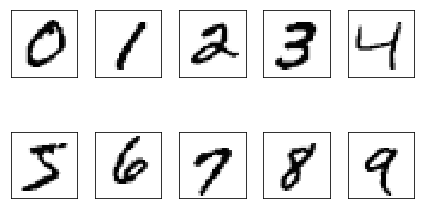

In [109]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

Visualiza 25 versiones diferentes de "5":

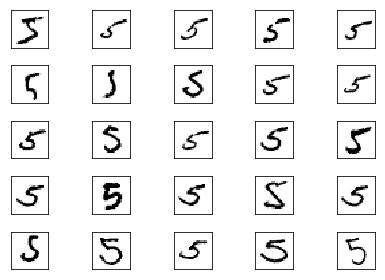

In [90]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 5][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_7.png', dpi=300)
plt.show()

In [110]:
## Changing labels to one-hot encoded vector
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print('Train labels dimension:');print(y_train.shape)
print('Test labels dimension:');print(y_test.shape)

Train labels dimension:
(50000, 10)
Test labels dimension:
(10000, 10)


### Definir la arquitectura de red La arquitectura 
será responsable de ver como entrada un Tensor de valores de píxeles de 784 dim para cada imagen, y de producir un Tensor de longitud 10 (nuestro número de clases) que indica las puntuaciones de clase para una imagen de entrada. Este ejemplo en particular usa dos capas ocultas y abandono para evitar el sobreajuste.


In [2]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit


ImportError: cannot import name 'Layer' from 'tensorflow.python.keras.engine.base_layer' (C:\Users\nyquist\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py)

In [112]:
## Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_0 = tf.Variable(tf.random_normal([num_features,num_layers_0], stddev=(1/tf.sqrt(float(num_features)))))
bias_0 = tf.Variable(tf.random_normal([num_layers_0]))
weights_1 = tf.Variable(tf.random_normal([num_layers_0,num_layers_1], stddev=(1/tf.sqrt(float(num_layers_0)))))
bias_1 = tf.Variable(tf.random_normal([num_layers_1]))
weights_2 = tf.Variable(tf.random_normal([num_layers_1,num_output], stddev=(1/tf.sqrt(float(num_layers_1)))))
bias_2 = tf.Variable(tf.random_normal([num_output]))


## Initializing weigths and biases
hidden_output_0 = tf.nn.relu(tf.matmul(input_X,weights_0)+bias_0)
hidden_output_0_0 = tf.nn.dropout(hidden_output_0, keep_prob)
hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0_0,weights_1)+bias_1)
hidden_output_1_1 = tf.nn.dropout(hidden_output_1, keep_prob)
predicted_y = tf.sigmoid(tf.matmul(hidden_output_1_1,weights_2) + bias_2)

## Defining the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=input_y)) \
        + regularizer_rate*(tf.reduce_sum(tf.square(bias_0)) + tf.reduce_sum(tf.square(bias_1)))

In [113]:
## Variable learning rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
## Adam optimzer for finding the right weight
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2,
                                                                         bias_0,bias_1,bias_2])

## Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [115]:
## Training parameters
batch_size = 128
epochs=10
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer, {input_X: X_train[arr[index:index+batch_size]],
                          input_y: y_train[arr[index:index+batch_size]],
                        keep_prob:dropout_prob})
    training_accuracy.append(s.run(accuracy, feed_dict= {input_X:X_train, 
                                                         input_y: y_train,keep_prob:1}))
    training_loss.append(s.run(loss, {input_X: X_train, 
                                      input_y: y_train,keep_prob:1}))
    
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(predicted_y, {input_X: X_test,keep_prob:1}).argmax(1)))
    
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))

Epoch:0, Train loss: 43.96 Train acc: 0.935, Test acc:0.934
Epoch:1, Train loss: 24.60 Train acc: 0.956, Test acc:0.954
Epoch:2, Train loss: 13.94 Train acc: 0.967, Test acc:0.964
Epoch:3, Train loss: 8.07 Train acc: 0.973, Test acc:0.967
Epoch:4, Train loss: 4.89 Train acc: 0.977, Test acc:0.969
Epoch:5, Train loss: 3.19 Train acc: 0.981, Test acc:0.974
Epoch:6, Train loss: 2.31 Train acc: 0.984, Test acc:0.974
Epoch:7, Train loss: 1.86 Train acc: 0.985, Test acc:0.977
Epoch:8, Train loss: 1.64 Train acc: 0.986, Test acc:0.979
Epoch:9, Train loss: 1.54 Train acc: 0.988, Test acc:0.977


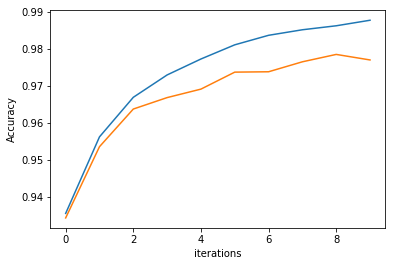

Train Accuracy: 0.99
Test Accuracy:0.98


In [117]:
## Plotting chart of training and testing accuracy as a function of iterations
iterations = list(range(epochs))
plt.plot(iterations, training_accuracy, label='Train')
plt.plot(iterations, testing_accuracy, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.show()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))

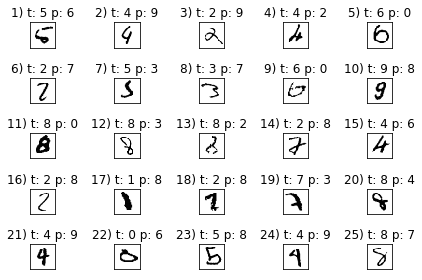

In [131]:
y_test_pred=np.uint8(s.run(predicted_y, {input_X: X_test,keep_prob:1}).argmax(1))
miscl_img = X_test[y_test1 != np.uint8(s.run(predicted_y, {input_X: X_test,keep_prob:1}).argmax(1))][:25]
correct_lab = y_test[y_test1 != np.uint8(s.run(predicted_y, {input_X: X_test,keep_prob:1}).argmax(1))][:25]
miscl_lab= y_test_pred[y_test1 != np.uint8(s.run(predicted_y, {input_X: X_test,keep_prob:1}).argmax(1))][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()